# Translation Similarity and Cost Analysis Notebook

This notebook performs the following tasks:
- Loads a translation dataset and computes sentence embeddings using the **LaBSE** model.
- Calculates cosine similarity between the English source and each translated text.
- Estimates translation cost based on token counts (using a GPT-4o tokenizer) and predefined pricing.
- Aggregates similarity and cost scores by translation type and computes a “benefit” metric.
- Buckets the results into categories and visualizes the final bucket scores with a heatmap.

In [1]:
import tiktoken
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
import math
import pandas as pd

# Set device based on availability (CUDA, MPS, or CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# Load LaBSE tokenizer and model for sentence embeddings
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/LaBSE")
model = AutoModel.from_pretrained("sentence-transformers/LaBSE")
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(501153, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

## Sentence Embedding Functions

The following functions are defined:
- **mean_pooling**: Pools the token embeddings using the attention mask.
- **get_embeds**: Tokenizes a list of sentences, passes them through the model, and returns normalized sentence embeddings.
- **get_similarity**: Computes cosine similarity between two embeddings.
- **get_sim_score**: Iterates through the dataset rows and computes similarity scores for all translation languages compared to English.

In [2]:
def mean_pooling(model_output, attention_mask):
    """
    Performs mean pooling on the token embeddings, taking the attention mask into account.
    """
    token_embeddings = model_output[0]
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )


def get_embeds(sentences):
    """
    Given a list of sentences, computes their embeddings using the LaBSE model.
    Returns normalized sentence embeddings.
    """
    sentences = [str(s) if pd.notnull(s) else "" for s in sentences]
    encoded_input = tokenizer(
        sentences, padding=True, truncation=True, return_tensors="pt"
    )
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}

    with torch.no_grad():
        model_output = model(**encoded_input)

    sentence_embeddings = mean_pooling(model_output, encoded_input["attention_mask"])
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    return sentence_embeddings


def get_similarity(embed_1, embed_2):
    """
    Computes cosine similarity between two embeddings.
    """
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    return cos(embed_1, embed_2)[0].item()


def get_sim_score(data):
    """
    Iterates through the dataset and computes similarity scores between the English text
    and its translations for each row.
    """
    cols = data.columns
    sim_scores = {lang: [] for lang in cols[1:]}
    for i in tqdm(range(len(data))):
        try:
            embeds = get_embeds(list(data.iloc[i][cols[:]]))
            for j, key in enumerate(sim_scores.keys()):
                sim_scores[key].append(get_similarity(embeds[[0]], embeds[[j + 1]]))
        except Exception as e:
            print(f"Error on row {i}: {e}")
            continue
    return sim_scores


# Load the translation data CSV
data = pd.read_csv("../data/educhat-translation/all_translations.csv")
# Compute similarity scores and save the mean similarity score per language as JSON.
sim_score = pd.DataFrame(get_sim_score(data)).mean().reset_index()
sim_score.columns = ["language", "score"]
sim_score.to_json("../results/sim-score.json", orient="records", indent=4)

100%|██████████| 60/60 [00:35<00:00,  1.67it/s]


In [3]:
sim_score = pd.DataFrame(get_sim_score(data))

100%|██████████| 60/60 [00:33<00:00,  1.80it/s]


## Tokenization and Cost Estimation

The following section uses the **tiktoken** library to count tokens for input and output texts.
It defines:
- **helper**: Calculates the number of tokens in a given string.
- **get_total**: Computes the total token count (with an offset adjustment for input tokens and prompt tokens).
The code then iterates over each translation language (other than English) to calculate a token DataFrame.

In [4]:
encoding = tiktoken.encoding_for_model("gpt-4o")


def helper(string: str, model_name: str) -> int:
    """
    Returns the number of tokens in a string based on the given model's encoding.
    """
    encoding = tiktoken.encoding_for_model(model_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


def get_total(input_text, output_text):
    """
    Given an input and output text, calculates the the token counts.
    """
    in_tokens = helper(input_text, "gpt-4o") + 13
    out_tokens = helper(output_text, "gpt-4o")
    return in_tokens + out_tokens


tokens = pd.DataFrame()

for lang in list(data.columns)[1:]:
    temp = []
    for i in range(len(data)):
        input_text = data["english"].iloc[i]
        output_text = data[lang].iloc[i]
        if isinstance(input_text, str) and isinstance(output_text, str):
            temp.append(get_total(input_text, output_text))
        else:
            temp.append(0)
    tokens[lang] = temp

## Aggregating Results and Bucketing Benefit Scores

This section reads in additional type information, merges it with the similarity and cost scores, and aggregates the results by translation type. It then computes a benefit score using an exponential transformation of the cost (with a scaling factor `alpha`) and buckets the scores into categories based on quantile thresholds.

In [5]:
# %% [code]
types = pd.read_csv("../data/educhat-translation/types.csv")

# Add type information to the similarity and cost DataFrames.
sim_score["types"] = types["type"]
tokens["types"] = types["type"]

# Group and aggregate by type.
sim_agg = sim_score.groupby("types").mean().T
tokens_agg = tokens.groupby("types").mean().T

alpha = 5e-4
benefit = pd.DataFrame()
for type in ["circular", "conversation", "email", "lessons", "misc"]:
    benefit[type] = sim_agg[type] * (-alpha * tokens_agg[type]).apply(
        lambda x: math.exp(x)
    )
benefit["mean"] = (
    benefit[["circular", "conversation", "email", "lessons", "misc"]]
    .T.mean()
    .apply(lambda x: round(x, 2))
)
benefit_describe = benefit.describe()

# Bucketing based on quantiles
buckets = {}
for lang in benefit.T:
    scores = benefit.loc[lang]
    entry = []
    num = 0
    for type in ["circular", "conversation", "email", "lessons", "misc"]:
        score = benefit.loc[lang][type]
        if score < benefit_describe[type]["25%"]:
            entry.append(round(1 * score, 2))
            num += 1 * score
        elif score < benefit_describe[type]["75%"]:
            entry.append(round(2 * score, 2))
            num += 2 * score
        else:
            entry.append(round(3 * score, 2))
            num += 3 * score
    entry.append(round(num / 5, 2))
    buckets[lang] = entry

buckets = pd.DataFrame(
    buckets, index=["circular", "conversation", "email", "lessons", "misc", "total"]
).T
buckets = buckets.sort_values(by=["total"], ascending=False)
buckets.index = buckets.index.str.title()
buckets.columns = buckets.columns.str.title()

## Visualization with Heatmap

Finally, the notebook uses **seaborn** and **matplotlib** to create a heatmap of the bucketing results. A custom colormap is defined with set boundaries, and annotations are added to the heatmap for clarity.

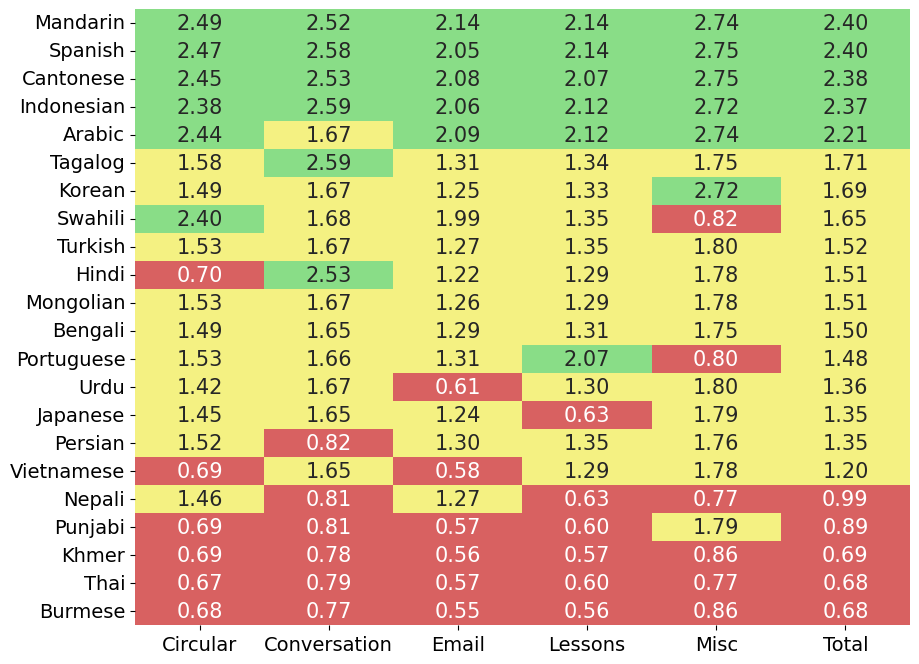

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define boundaries and a custom color map.
boundaries = [0, 1, 2, 3]
colors = ["#D86161", "#F4F282", "#89DD87"]  # Lighter red, yellow, green.
cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors)
norm = mcolors.BoundaryNorm(boundaries, ncolors=cmap.N, clip=True)

plt.figure(figsize=(10, 8))

# Create the heatmap with annotations.
ax = sns.heatmap(
    buckets,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    norm=norm,
    cbar_kws={"ticks": boundaries},
    cbar=False,
    annot_kws={"size": 15},  # Increase annotation font size.
)

# Optionally, set tick label sizes.
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

## Summary

- **Embedding Computation:** We used the LaBSE model to compute sentence embeddings for each row of translations.
- **Similarity and Cost:** Cosine similarity is calculated between the English text and its translations, and token-based cost estimation is performed.
- **Aggregation and Bucketing:** Data is aggregated by translation type and a benefit metric is computed. The scores are then bucketed for comparative analysis.
- **Visualization:** A heatmap is generated to visually inspect the bucketed benefit scores across different languages.